In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import PRF
import tessreduce as tr
import matplotlib.pyplot as plt
%matplotlib widget
from skimage.util.shape import view_as_windows
from scipy.optimize import minimize
from tqdm import tqdm

getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
Aligning images


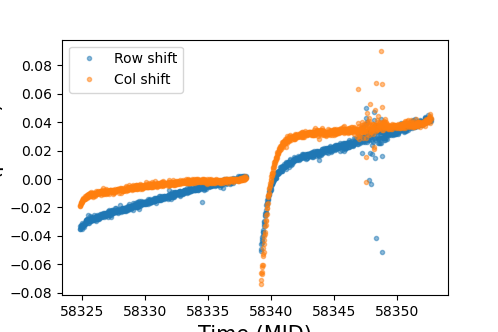

!!Re-running for difference image!!
shifting images
7
remade mask
background
Background correlation correction
Field calibration
Target is below -30 dec, calibrating to SkyMapper photometry.


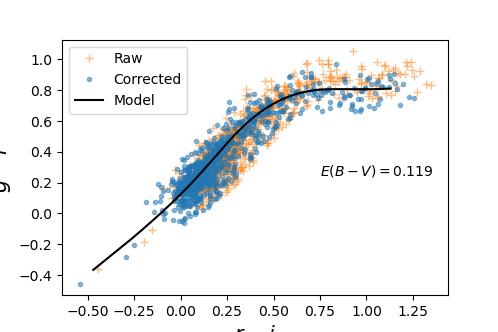

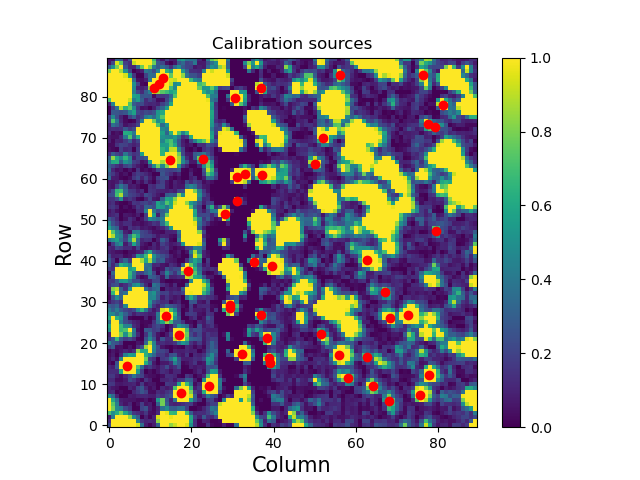

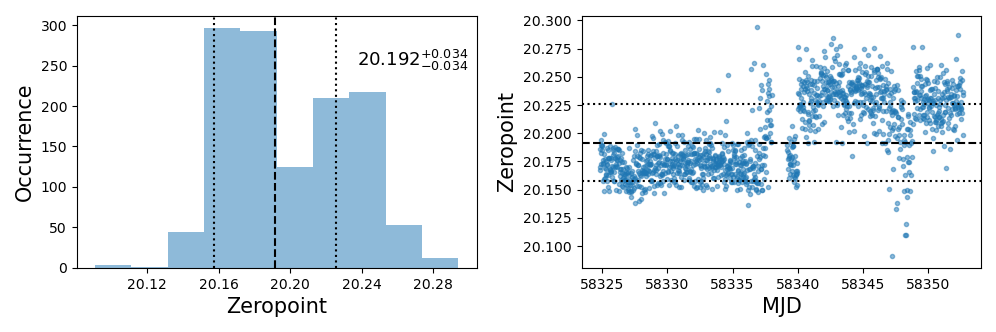

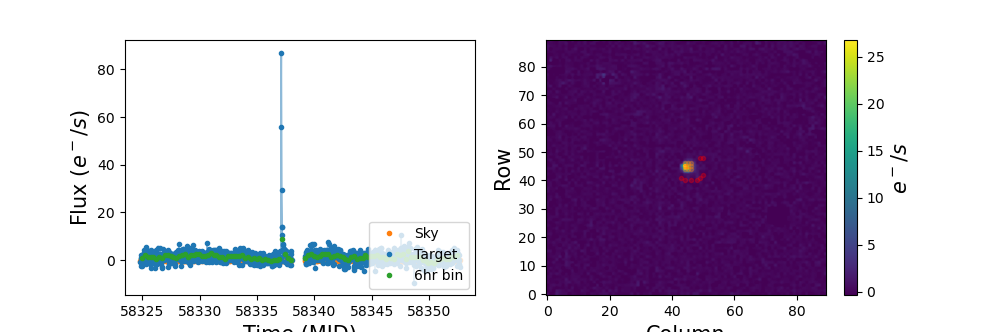

In [2]:
tess = tr.tessreduce(ra=348.786,dec=-45.328,sector=1,plot=True,reduce=True,phot_method='psf')

getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
Aligning images


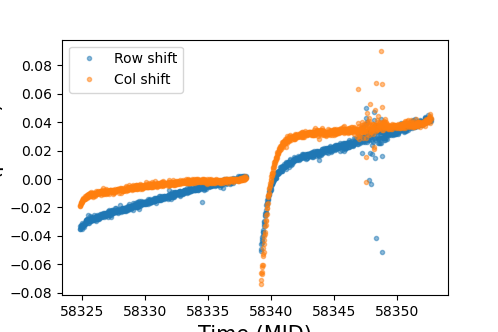

!!Re-running for difference image!!
shifting images
7
remade mask
background
Background correlation correction
Field calibration
Target is below -30 dec, calibrating to SkyMapper photometry.


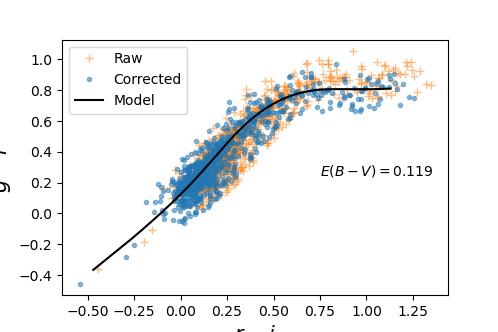

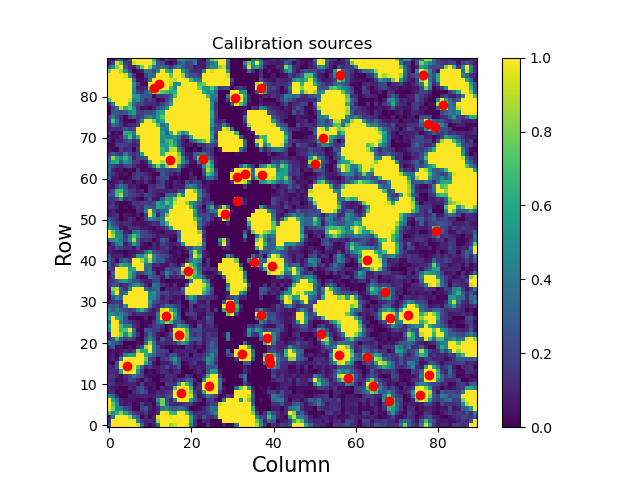

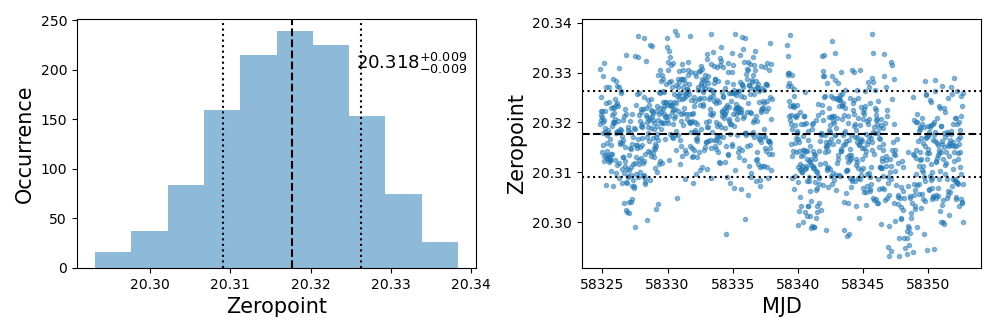

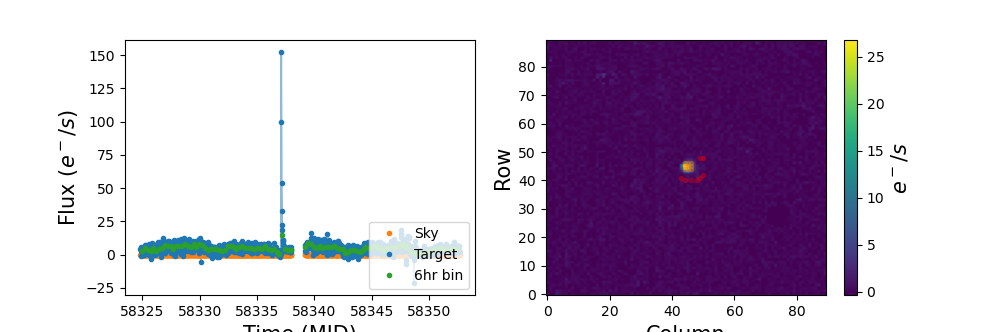

In [6]:
tess = tr.tessreduce(ra=348.786,dec=-45.328,sector=1,plot=True,reduce=True,phot_method='aperture')

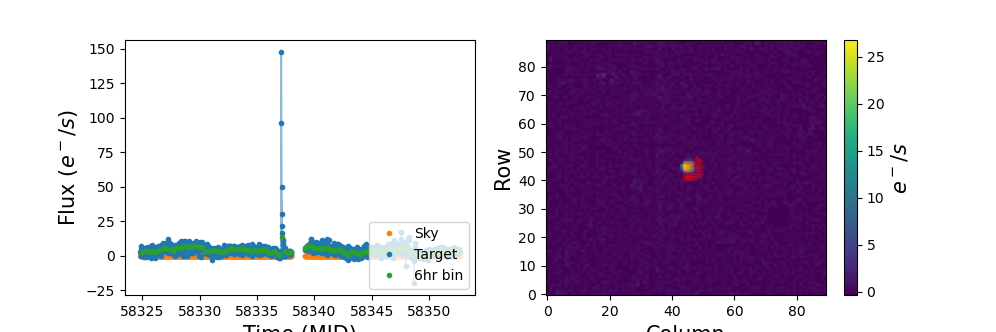

In [4]:
l,_=tess.diff_lc(phot_method='aperture')

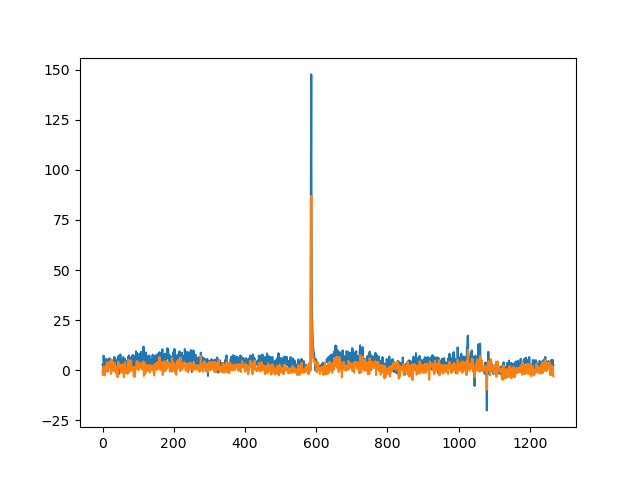

In [5]:
plt.figure()
plt.plot(l[1])
plt.plot(tess.lc[1])

In [16]:
from scipy.ndimage import shift

def downSample2d(arr,sf):

    isf2 = 1.0/(sf*sf)    # scalefactor
    windows = view_as_windows(arr, (sf,sf), step = sf)  # automatically scale down
    return windows.sum(3).sum(2)*isf2

class create_psf():
    def __init__(self,prf,size,repFact=10):
        
        self.prf = prf
        self.size = size
        self.source_x = 0         # offset of source from centre
        self.source_y = 0         # offset of source from centre
        self.repFact=repFact     # supersample multiplication

        # -- Finds centre of kernel -- #
        self.cent=self.size/2.-0.5

        self.psf = None

    def source(self,shiftx=0,shifty=0,ext_shift=[0,0]):
        
        centx_s = self.cent + shiftx    # source centre
        centy_s = self.cent + shifty

        psf = self.prf.locate(centx_s-ext_shift[1],centy_s-ext_shift[0], (self.size,self.size))
        psf = shift(psf,ext_shift)
        self.psf = psf/np.nansum(psf)

    def minimize_position(self,coeff,image,ext_shift):

        self.source_x = coeff[0]
        self.source_y = coeff[1]
        
        # -- generate psf -- #
        self.source(shiftx = self.source_x, shifty = self.source_y,ext_shift=ext_shift)

        # -- calculate residuals -- #
        diff = abs(image - self.psf)
        residual = np.nansum(diff)
        return np.exp(residual)
    
    def psf_position(self,image,limx=1,limy=1,ext_shift=[0,0]):
        """
        Fit the PSF. Limx,y dictates bounds for position of the source
        """

        normimage = image / np.nansum(image)    # normalise the image
        coeff = [self.source_x,self.source_y]
        lims = [[-limx,limx],[-limy,limy]]
        
        # -- Optimize -- #
        res = minimize(self.minimize_position, coeff, args=(normimage,ext_shift), method='Powell',bounds=lims)
        self.psf_fit = res

    def minimize_psf_flux(self,coeff,image):
        res = np.nansum(abs(image - self.psf*coeff[0]))
        return res

    def psf_flux(self,image,ext_shift=None):
        if self.psf is None:
            self.source(shiftx=self.source_x,shifty=self.source_y)
        if ext_shift is not None:
            self.source(ext_shift=ext_shift)
            
        mask = np.zeros_like(self.psf)
        mask[self.psf > np.nanpercentile(self.psf,70)] = 1
        f0 = np.nansum(image*mask)
        bkg = np.nanmedian(image[~mask.astype(bool)])
        image = image - bkg
        
        #f0 = np.nansum(image)

        res = minimize(self.minimize_psf_flux,f0,args=(image),method='Nelder-Mead')
        self.flux = res.x[0]
        self.image_residual = image - self.psf*self.flux

def _psf_initialise(trObj,cutoutSize,loc,ref=False):
    """
    For gathering the cutouts and PRF base.
    """

    col = trObj.tpf.column - int(trObj.size/2-1) + loc[0] # find column and row, when specifying location on a *say* 90x90 px cutout
    row = trObj.tpf.row - int(trObj.size/2-1) + loc[1] 
        
    prf = PRF.TESS_PRF(trObj.tpf.camera,trObj.tpf.ccd,trObj.tpf.sector,col,row) # initialise psf kernel
    if ref:
        cutout = (trObj.flux+trObj.ref)[:,loc[1]-cutoutSize//2:loc[1]+1+cutoutSize//2,loc[0]-cutoutSize//2:loc[0]+1+cutoutSize//2] # gather cutouts
    else:
        cutout = trObj.flux[:,loc[1]-cutoutSize//2:loc[1]+1+cutoutSize//2,loc[0]-cutoutSize//2:loc[0]+1+cutoutSize//2] # gather cutouts
    return prf, cutout

def psf_photometry(trObj,xPix,yPix,size=7,repFact=10,snap=None,ext_shift=False,plot=False,diff=None):
    """
    Main Function! Just switch trObj to self inside tessreduce and all should follow.

    --------
    Inputs:
    
    trObj : tessreduce object
    xPix : x pixel location of target region
    yPix : y pixel location of target region
    size : size of cutout to use (should be odd)
    repFact : super sampling factor for modelling
    
    --------
    Options:

    snap : Determines how psf position is fit.
        - None = each frame's position will be fit and used when fitting for flux
        - 'brightest' = the position of the brightest cutout frame will be applied to all subsequent frames
        - int = providing an integer allows for explicit choice of which frame to use as position reference
        - 'ref' = use the reference as the position fit point

    --------
    Returns:

    flux : flux light curve across entire sector.

    """
    if diff is None:
        diff = trObj.diff
    flux = []

    if snap == None:  # if no snap, each cutout has their position fitted and considered during flux fitting
        prf, cutouts = _psf_initialise(trObj,size,(xPix,yPix))   # gather base PRF and the array of cutouts data
        xShifts = []
        yShifts = []
        for cutout in tqdm(cutouts):
            PSF = create_psf(prf,size,repFact)
            PSF.psf_position(cutout)
            PSF.psf_flux(cutout)
            flux.append(PSF.flux)
            yShifts.append(PSF.source_y)
            xShifts.append(PSF.source_x)
        if plot:
            fig,ax = plt.subplots(ncols=3,figsize=(12,4))
            ax[0].plot(flux)
            ax[0].set_ylabel('Flux')
            ax[1].plot(xShifts,marker='.',linestyle=' ')
            ax[1].set_ylabel('xShift')
            ax[2].plot(yShifts,marker='.',linestyle=' ')
            ax[2].set_ylabel('yShift')

    elif type(snap) == str:
        if snap == 'brightest': # each cutout has position snapped to brightest frame fit position
            prf, cutouts = _psf_initialise(trObj,size,(xPix,yPix),(not diff))   # gather base PRF and the array of cutouts data
            ind = np.where(cutouts==np.nanmax(cutouts))[0][0]
            ref = cutouts[ind]
            base = create_psf(prf,size)
            base.psf_position(ref,ext_shift=trObj.shift[ind])
        elif snap == 'ref':
            prf, cutouts = _psf_initialise(trObj,size,(xPix,yPix),ref=True)   # gather base PRF and the array of cutouts data
            ref = cutouts[trObj.ref_ind]
            base = create_psf(prf,size)
            base.psf_position(ref)
            if diff:
                _, cutouts = _psf_initialise(trObj,size,(xPix,yPix),ref=False)
        for i in range(len(cutouts)):
            PSF = create_psf(prf,size,repFact)
            PSF.source_x = base.source_x
            PSF.source_y = base.source_y
            if ext_shift:
                shift =trObj.shift[i] 
                if ~np.isfinite(shift).all():
                    shift = [0,0]
                PSF.psf_flux(cutouts[i],ext_shift=shift)
            else:
                PSF.psf_flux(cutouts[i])
            flux.append(PSF.flux)
        if plot:
            fig = plt.figure()
            plt.plot(flux)
            plt.ylabel('Flux')
        
    
    elif type(snap) == int:       # each cutout has position snapped to 'snap' frame fit position (snap is integer)
        base = create_psf(prf,size)
        base.psf_position(cutouts[snap])
        for cutout in tqdm(cutouts):
            PSF = create_psf(prf,size,repFact)
            PSF.source_x = base.source_x
            PSF.source_y = base.source_y
            PSF.psf_flux(cutout)
            flux.append(PSF.flux)
        if plot:
            fig,ax = plt.subplots(ncols=1,figsize=(12,4))
            ax.plot(flux)
            ax.set_ylabel('Flux')
    flux = np.array(flux)
    return flux


In [26]:
~np.isfinite(tess.shift[628]).all()

True

In [215]:
flux= psf_photometry(tess,45,45,snap='brightest',size=7)
flux2= psf_photometry(tess,45,45,snap='brightest',size=7,ext_shift=True,diff=True)

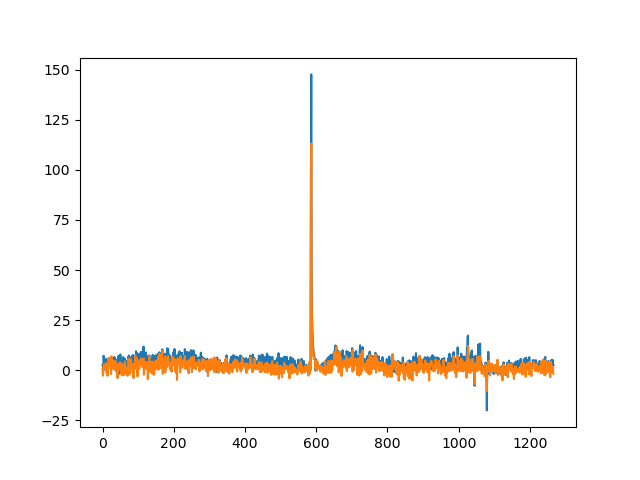

In [217]:
plt.figure()
a,_ = tess.diff_lc(x=45,y=45,diff=True)
plt.plot(a[1],label='aperture phot',)
#plt.plot(flux+10,label='psf phot')
plt.plot(flux2,label='psf phot')


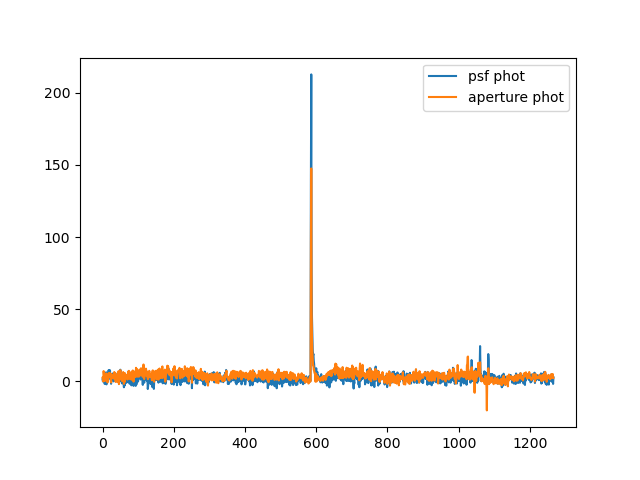

In [211]:
plt.figure()
plt.plot(flux,label='psf phot')
#plt.plot(tess.lc[1],label='aperture phot')
a,_ = tess.diff_lc(x=45,y=45,diff=True)
plt.plot(a[1],label='aperture phot',)
plt.legend()

getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
Aligning images
!!Re-running for difference image!!
shifting images
7
remade mask
background
Background correlation correction
Field calibration
Target is above -30 dec, calibrating to PS1 photometry.


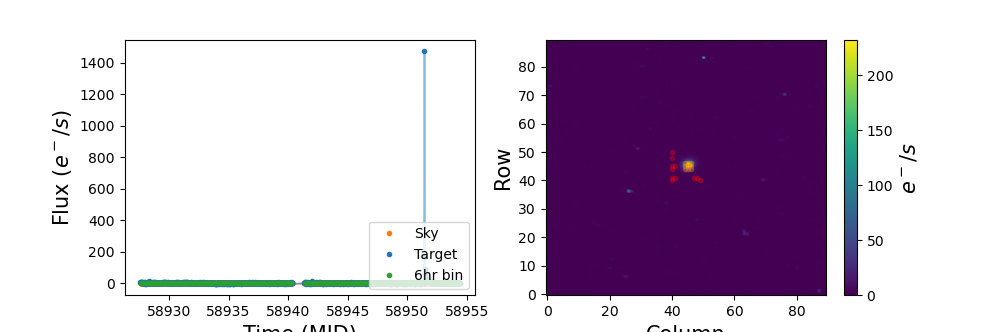

In [3]:
grb = tr.tessreduce(ra=278.313,dec=62.532,sector=23,plot=False,reduce=True)

In [6]:
l = tess.to_mag()

In [8]:
l.shape

(3, 1267)

(20.0, 15.0)

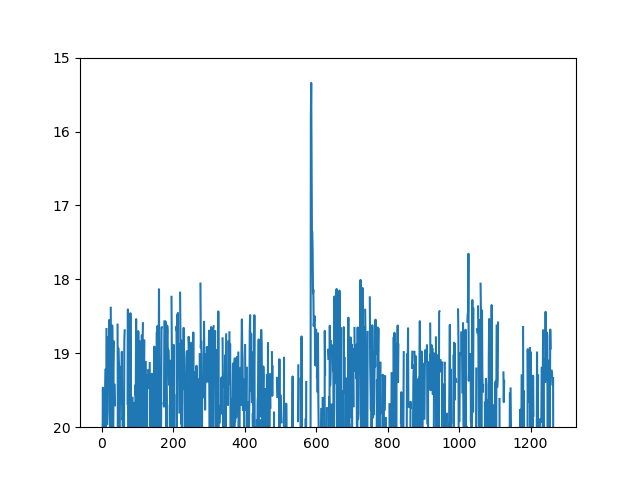

In [11]:
plt.figure()
plt.plot(l[1])
plt.ylim(20,15)

In [182]:
f = psf_photometry(grb,45,45,snap='brightest',size=7,ext_shift=True)

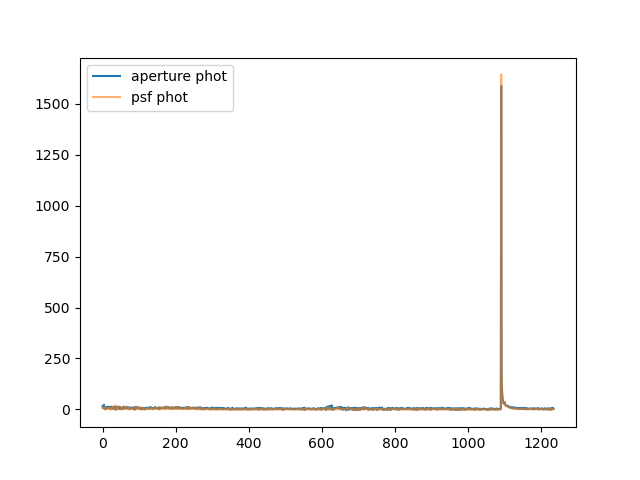

In [185]:
plt.figure()
plt.plot(grb.lc[1],label='aperture phot')
plt.plot(f,label='psf phot',alpha=0.6)

plt.legend()

In [13]:
obs = tr.spacetime_lookup(134.0484380,-3.3255440,59980)

|   Sector | Covers   |   Time difference  |
|          |          |             (days) |
|----------+----------+--------------------|
|        8 | False    |              -1438 |
|       34 | False    |               -726 |
|       61 | True     |                  0 |


getting TPF from TESScut
made reference
7
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
7
made source mask
calculating background
background subtracted
Aligning images


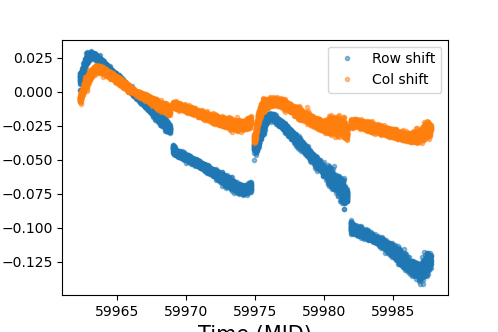

!!Re-running for difference image!!
shifting images
7
remade mask
background
Background correlation correction
Field calibration
Target is above -30 dec, calibrating to PS1 photometry.


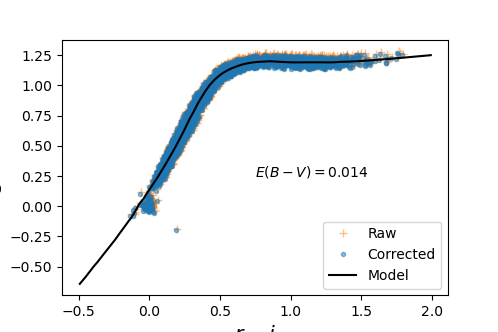

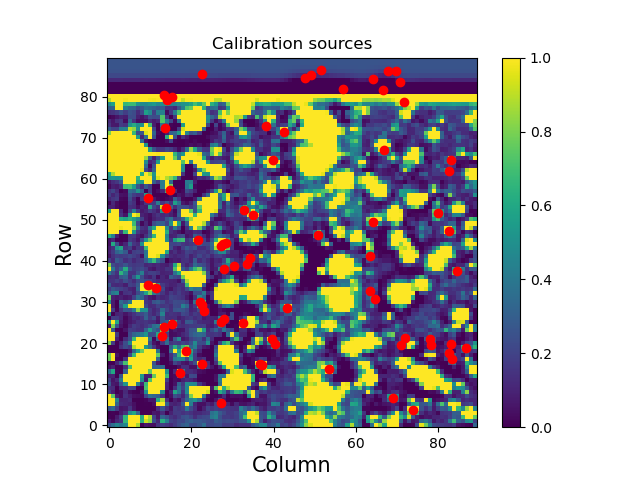

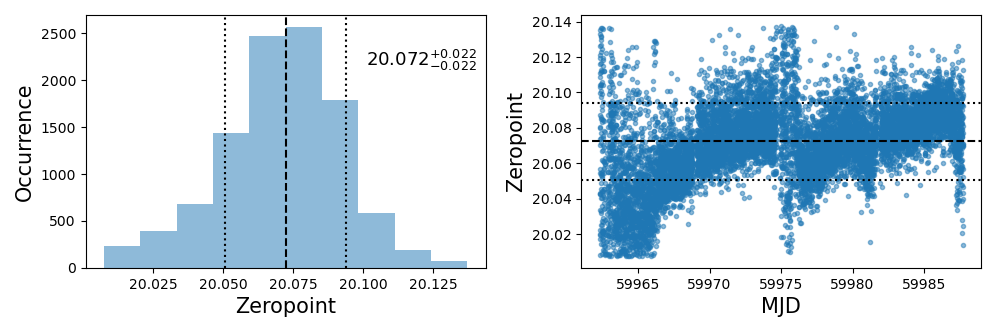

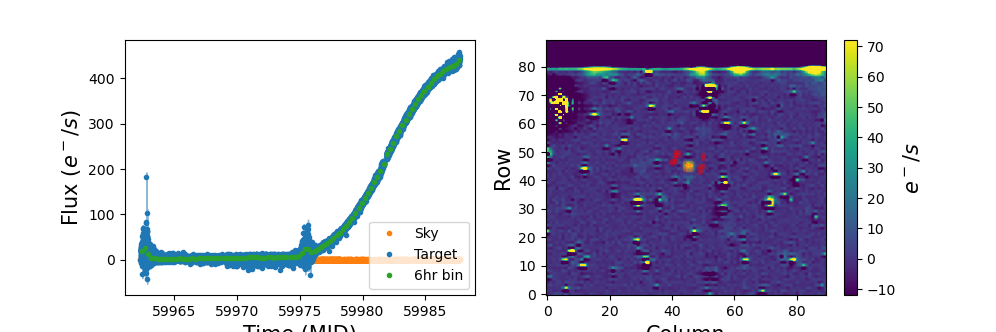

In [14]:
tess = tr.tessreduce(obs_list=obs,plot=True,reduce=True)

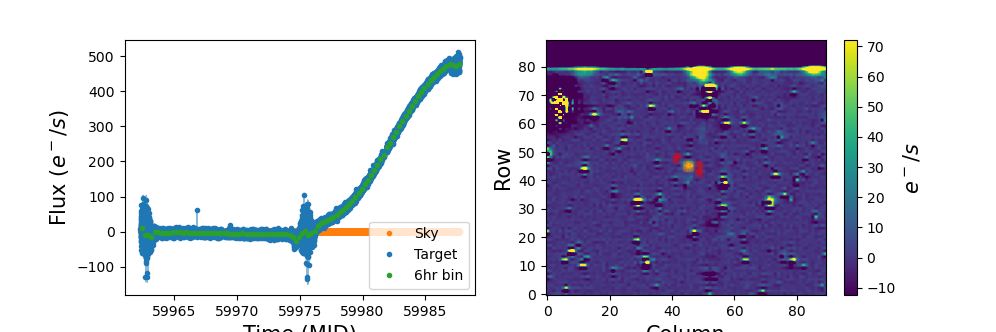

In [20]:
l,_ = tess.diff_lc(phot_method='aperture')

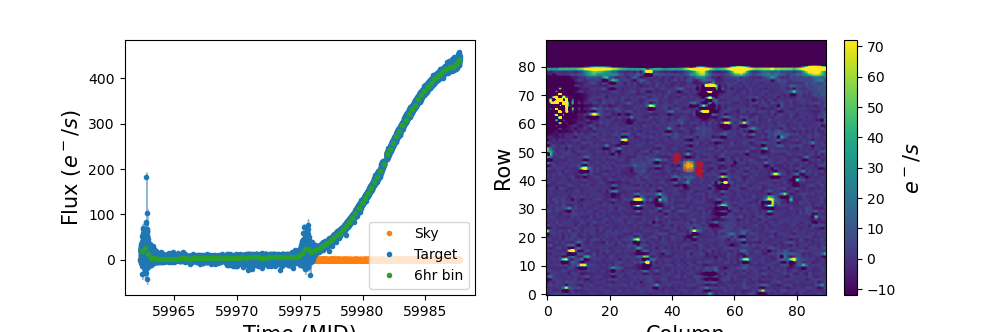

In [37]:
lp,_ = tess.diff_lc()

In [45]:
tess.tzp

20.072348077949865

In [47]:
tessap.tzp

19.970934595429423

getting TPF from TESScut
made reference
7
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
7
made source mask
calculating background
background subtracted
Aligning images


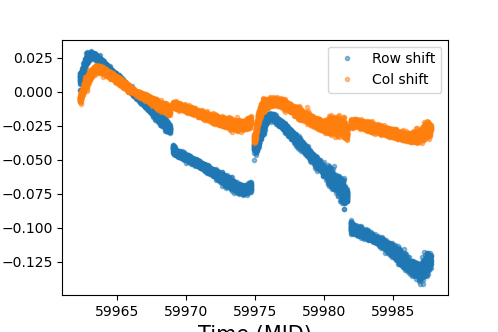

!!Re-running for difference image!!
shifting images
7
remade mask
background
Background correlation correction
Field calibration
Target is above -30 dec, calibrating to PS1 photometry.


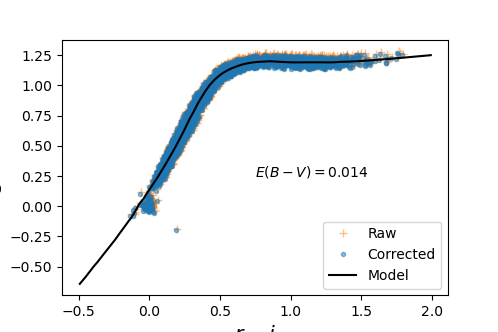

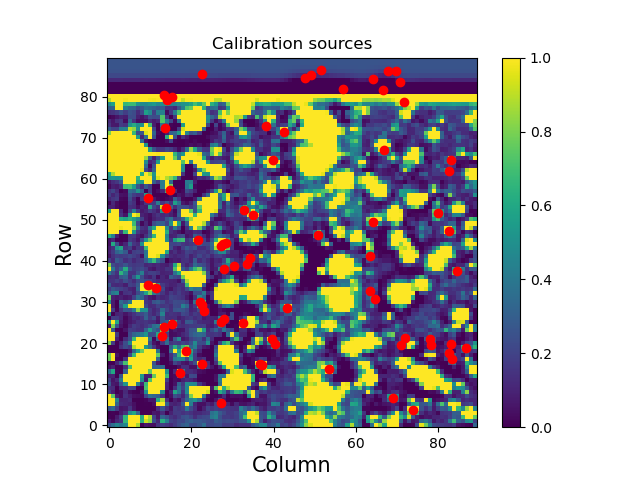

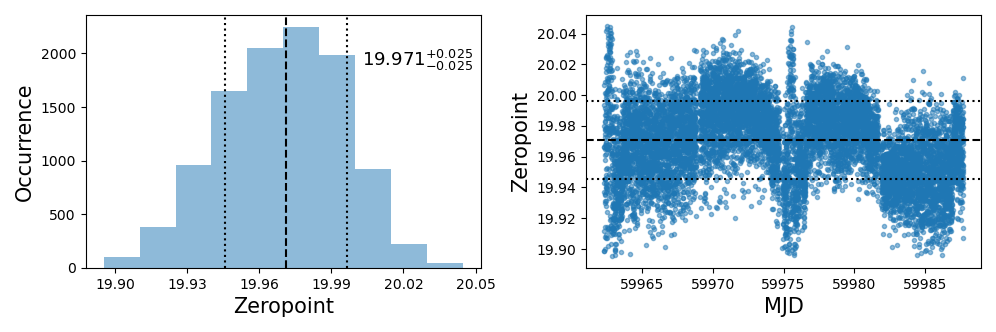

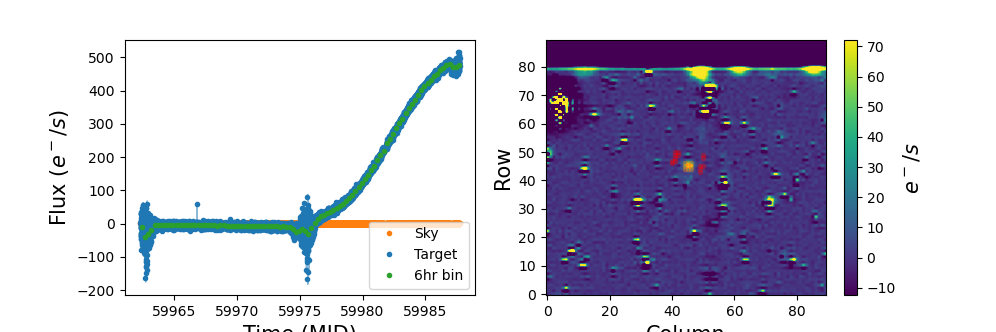

In [46]:
tessap = tr.tessreduce(obs_list=obs,plot=True,reduce=True,phot_method='aperture')

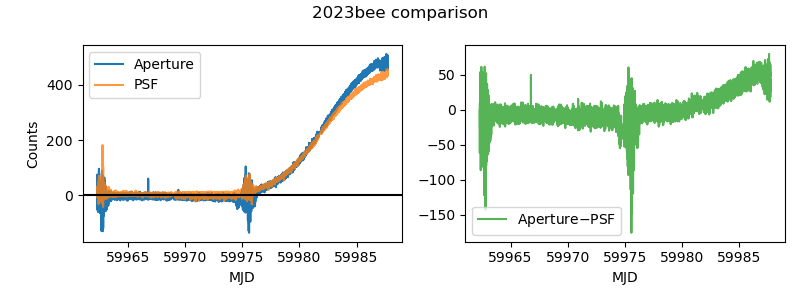

In [43]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(tess.lc[0],l[1],label='Aperture')
plt.plot(tess.lc[0],lp[1],alpha=0.8,label='PSF')
plt.axhline(0,c='k')
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Counts')

plt.subplot(122)
plt.plot(tess.lc[0],l[1]-lp[1],'C2',alpha=0.8,label=r'Aperture$-$PSF')
plt.legend()
plt.xlabel('MJD')
plt.suptitle('2023bee comparison')
plt.tight_layout()

plt.savefig('ApvsPSF_2023bee.png')

Welcome to the API of the Open Astronomy Catalogs! Please see https://github.com/astrocatalogs/OACAPI for API examples.
Event alias not found in any catalog.


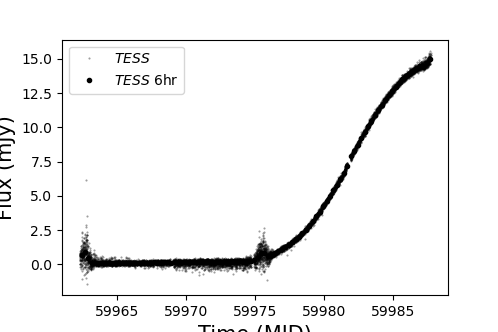

In [34]:
tess.plotter(ground=True)

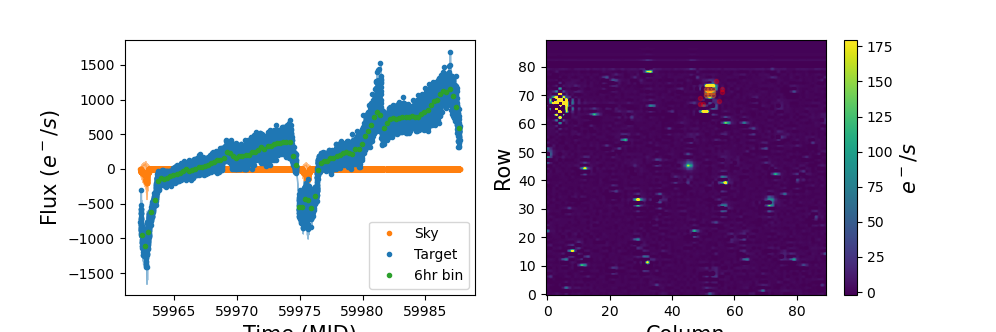

(array([[ 5.99623045e+04,  5.99623068e+04,  5.99623091e+04, ...,
          5.99877238e+04,  5.99877261e+04,  5.99877284e+04],
        [-7.71703798e+02, -7.10324544e+02, -7.26486257e+02, ...,
          4.79728185e+02,  6.24190176e+02,  4.22133951e+02],
        [ 6.69950887e+00,  6.86486053e+00,  4.44163196e+00, ...,
          1.28756582e+01,  1.22160423e+01,  1.22071244e+01]]),
 array([[ 5.99623045e+04,  5.99623068e+04,  5.99623091e+04, ...,
          5.99877238e+04,  5.99877261e+04,  5.99877284e+04],
        [-6.69647408e+00, -1.35463264e+01, -5.42991613e+00, ...,
         -4.37188026e+00, -3.17628090e+00, -2.38233912e+00],
        [ 6.69950887e+00,  6.86486053e+00,  4.44163196e+00, ...,
          1.28756582e+01,  1.22160423e+01,  1.22071244e+01]]))

In [19]:
tess.diff_lc(x=52,y=71,phot_method='psf')